In [1]:
import os
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
import pandas as pd
import numpy as np
import random
import json
import scipy.sparse as sp
import itertools
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# Process Cora
cora_dir = "./datasets/cora/"
nodes_id_map = {}
start = 0
start_list, target_list = [], []
with open(cora_dir+"cora.cites") as f:
    for ln in f:
        ln = ln.strip("\n").split("\t")
        start_i, target_i = int(ln[0]), int(ln[1])
        if start_i not in nodes_id_map:
            nodes_id_map[start_i] = start
            start += 1
        if target_i not in nodes_id_map:
            nodes_id_map[target_i] = start
            start += 1 
        start_list.append(nodes_id_map[start_i])
        target_list.append(nodes_id_map[target_i])
        start_list.append(nodes_id_map[target_i])
        target_list.append(nodes_id_map[start_i])
        

feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(cora_dir+"cora.content"), sep='\t', header=None, names=column_names)

cora_label_map = {
      'Case_Based': 0,
      'Genetic_Algorithms': 1,
      'Neural_Networks': 2,
      'Probabilistic_Methods': 3,
      'Reinforcement_Learning': 4,
      'Rule_Learning': 5,
      'Theory': 6,
  }

cora_features = [None for _ in range(len(nodes_id_map))]
cora_labels = [None for _ in range(len(nodes_id_map))]
for i in range(node_data.shape[0]):
    feature_i, label_i = node_data.iloc[i][:-1], cora_label_map[node_data.iloc[i].tolist()[-1]]
    node_index_i = nodes_id_map[node_data.index[i]]
    cora_features[node_index_i] = feature_i
    cora_labels[node_index_i] = label_i

G_cora = dgl.DGLGraph()
G_cora.add_edges(start_list, target_list)
G_cora.ndata['feat'] = torch.Tensor(np.array(cora_features, dtype=np.float64))
G_cora.ndata['label'] = torch.Tensor(np.array(cora_labels)).type(torch.int64)

train_size = int(0.8*len(cora_labels))
val_size = int((len(cora_labels)-train_size)/2)

all_d = set([i for i in range(len(cora_labels))])
train_mask = set(random.sample(all_d, train_size))
val_mask = set(random.sample(all_d-train_mask, val_size))
test_mask = all_d-train_mask-val_mask

G_cora.ndata['train_mask'] = torch.Tensor(np.array([True if i in train_mask else False for i in range(len(all_d))])).type(torch.bool)
G_cora.ndata['val_mask'] = torch.Tensor(np.array([True if i in val_mask else False for i in range(len(all_d))])).type(torch.bool)
G_cora.ndata['test_mask'] = torch.Tensor(np.array([True if i in test_mask else False for i in range(len(all_d))])).type(torch.bool)


/data/sihua.qi/my_env/mypy36/lib/python3.7/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [2]:
# Process CiteSeer
citeseer_dir = "./datasets/citeseer/"
nodes_id_map = {}
start_list, target_list = [], []
start = 0
node_data = pd.read_csv(os.path.join(citeseer_dir+"citeseer.content"), sep='\t', header=None)
node_data_id_set = set([str(i) for i in node_data[0].tolist()])
with open(citeseer_dir+"citeseer.cites") as f:
    for ln in f:
        ln = ln.strip("\n").split("\t")
        start_i, target_i = ln[0], ln[1]
        if start_i not in node_data_id_set or target_i not in node_data_id_set:
            continue
        if start_i not in nodes_id_map:
            nodes_id_map[start_i] = start
            start += 1
        if target_i not in nodes_id_map:
            nodes_id_map[target_i] = start
            start += 1 
        start_list.append(nodes_id_map[start_i])
        target_list.append(nodes_id_map[target_i])
        start_list.append(nodes_id_map[target_i])
        target_list.append(nodes_id_map[start_i])

citeseer_label_map = {
    "Agents": 0,
	"AI": 1,
	"DB": 2,
	"IR": 3,
	"ML": 4,
    "HCI": 5
}


citeseer_features = [None for _ in range(len(nodes_id_map))]
citeseer_labels = [None for _ in range(len(nodes_id_map))]
for i in range(node_data.shape[0]):
    tmp_i = node_data.iloc[i].tolist()
    feature_i, label_i = tmp_i[1:-1], citeseer_label_map[tmp_i[-1]]
    node_index_i = nodes_id_map[str(tmp_i[0])]
    citeseer_features[node_index_i] = feature_i
    citeseer_labels[node_index_i] = label_i

G_citeseer = dgl.DGLGraph()
G_citeseer.add_edges(start_list, target_list)
G_citeseer.ndata['feat'] = torch.Tensor(np.array(citeseer_features, dtype=np.float64))
G_citeseer.ndata['label'] = torch.Tensor(np.array(citeseer_labels)).type(torch.int64)

train_size = int(0.8*len(citeseer_labels))
val_size = int((len(citeseer_labels)-train_size)/2)
all_d = set([i for i in range(len(citeseer_labels))])
train_mask = set(random.sample(all_d, train_size))
val_mask = set(random.sample(all_d-train_mask, val_size))
test_mask = all_d-train_mask-val_mask

G_citeseer.ndata['train_mask'] = torch.Tensor(np.array([True if i in train_mask else False for i in range(len(all_d))])).type(torch.bool)
G_citeseer.ndata['val_mask'] = torch.Tensor(np.array([True if i in val_mask else False for i in range(len(all_d))])).type(torch.bool)
G_citeseer.ndata['test_mask'] = torch.Tensor(np.array([True if i in test_mask else False for i in range(len(all_d))])).type(torch.bool)

/data/sihua.qi/my_env/mypy36/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/data/sihua.qi/my_env/mypy36/lib/python3.7/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [3]:
# Process PPI
ppi_dir = "./datasets/ppi/"

ppi_class_map = json.load(open(ppi_dir+"ppi-class_map.json"))
ppi_graph = json.load(open(ppi_dir+"ppi-G.json"))
ppi_features = np.load(ppi_dir+"ppi-feats.npy")
ppi_id_map = json.load(open(ppi_dir+"ppi-id_map.json"))

ppi_labels = []
start_list, target_list = [], []
for i in ppi_graph["links"]:
    start_list.append(i["source"])
    target_list.append(i["target"])
for i in range(len(ppi_id_map)):
    ppi_labels.append(ppi_class_map[str(i)])

G_ppi = dgl.DGLGraph()
G_ppi.add_edges(start_list, target_list)
G_ppi.ndata['feat'] = torch.Tensor(np.array(ppi_features, dtype=np.float64))
G_ppi.ndata['label'] = torch.Tensor(np.array(ppi_labels)).type(torch.float32)


train_mask = [None for _ in range(len(ppi_id_map))]
val_mask = [None for _ in range(len(ppi_id_map))]
test_mask = [None for _ in range(len(ppi_id_map))]
for i in ppi_graph["nodes"]:
    if i["test"]:
        test_mask[i["id"]] = True
    else:
        test_mask[i["id"]] = False
    if i["val"]:
        val_mask[i["id"]] = True
    else:
        val_mask[i["id"]] = False
    if not val_mask[i["id"]] and not test_mask[i["id"]]:
        train_mask[i["id"]] = True
    else:
        train_mask[i["id"]] = False

G_ppi.ndata['train_mask'] = torch.Tensor(np.array(train_mask)).type(torch.bool)
G_ppi.ndata['val_mask'] = torch.Tensor(np.array(val_mask)).type(torch.bool)
G_ppi.ndata['test_mask'] = torch.Tensor(np.array(test_mask)).type(torch.bool)

In [4]:
def prepare_edge_data(input_g, if_ppi=False):
    u, v = input_g.edges()
    eids = np.arange(input_g.number_of_edges())
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * 0.1)
    val_size = test_size
    train_size = input_g.number_of_edges() - test_size - val_size
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    val_pos_u, val_pos_v = u[eids[test_size:test_size+val_size]], v[eids[test_size:test_size+val_size]]
    train_pos_u, train_pos_v = u[eids[test_size+val_size:]], v[eids[test_size+val_size:]]

    # Find all negative edges and split them for training and testing
    adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
    adj = adj.todense()
    if if_ppi:
        adj = np.pad(adj, [(0, adj.shape[1]-adj.shape[0]), (0, 0)], mode='constant', constant_values=0)

    adj_neg = 1 - adj - np.eye(input_g.number_of_nodes())
    neg_u, neg_v = np.where(adj_neg != 0)

    neg_eids = np.random.choice(len(neg_u), input_g.number_of_edges())
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    val_neg_u, val_neg_v = neg_u[neg_eids[test_size:test_size+val_size]], neg_v[neg_eids[test_size:test_size+val_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size+val_size:]], neg_v[neg_eids[test_size+val_size:]]

    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=input_g.number_of_nodes())
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=input_g.number_of_nodes())

    val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=input_g.number_of_nodes())
    val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=input_g.number_of_nodes())

    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=input_g.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=input_g.number_of_nodes())

    train_g = dgl.remove_edges(input_g, eids[:test_size+val_size])
    return train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g

In [5]:
from dgl.function import copy_src, sum as fn_sum, u_dot_v
from dgl.utils import expand_as_pair

class GraphConv(nn.Module):
    def __init__(self, in_feats, out_feats, activation=None,):
        super(GraphConv, self).__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.bias = nn.Parameter(torch.Tensor(out_feats))
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.zeros_(self.bias)

    def forward(self, graph, feat, weight=None):
        with graph.local_scope():
            aggregate_fn = copy_src('h', 'm')
            feat_src, feat_dst = expand_as_pair(feat, graph)
            degs = graph.out_degrees().float().clamp(min=1)
            norm = torch.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feat_src.dim() - 1)
            norm = torch.reshape(norm, shp)
            feat_src = feat_src * norm
            weight = self.weight

            feat_src = torch.matmul(feat_src, weight)
            graph.srcdata['h'] = feat_src
            graph.update_all(aggregate_fn, fn_sum(msg='m', out='h'))
            rst = graph.dstdata['h']

            degs = graph.in_degrees().float().clamp(min=1)
            norm = torch.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feat_dst.dim() - 1)
            norm = torch.reshape(norm, shp)
            rst = rst * norm
            rst = rst + self.bias

            return rst 


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, layers=2, if_ppi=False, 
                 if_activate=True, if_normal=True, if_dropout=False):
        super(GCN, self).__init__()
        self.if_ppi = if_ppi
        self.layers = layers
        self.if_activate = if_activate
        self.if_dropout = if_dropout
        self.if_normal = if_normal
        if layers>2:
            self.linears = torch.nn.ModuleList([GraphConv(h_feats, h_feats) for _ in range(layers-2)])
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.dropout = torch.nn.Dropout(p=0.5, inplace=False)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        if self.if_activate:
            h = F.relu(h)
        if self.layers > 2:
            for i, l in enumerate(self.linears):
                h = l(g, h)
        if self.if_activate:
            h = F.relu(h)
        if self.if_dropout:
            h = self.dropout(h)
        if self.if_normal:
            h = torch.nn.functional.normalize(h)
        h = self.conv2(g, h)
        return h
        

# class GCN(nn.Module):
#     def __init__(self, in_feats, h_feats):
#         super(GCN, self).__init__()
#         self.conv1 = GraphConv(in_feats, h_feats)
#         self.conv2 = GraphConv(h_feats, h_feats)

#     def forward(self, g, in_feat):
#         h = self.conv1(g, in_feat)
#         h = F.relu(h)
#         h = self.conv2(g, h)
#         return h

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)


In [6]:
def train(train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g, model, pred, epochs=200, print_epoch=20, lr=0.01,if_print=False):
    best_val_auc = 0.0
    best_test_auc = 0.0
    all_loss = []
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=lr)
    for e in range(epochs):
        # forward
        model.zero_grad()
        model.train()
        h = model(train_g, train_g.ndata['feat'])
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)
        all_loss.append(loss.detach().numpy())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if e % print_epoch == 0:
            model.eval()
            with torch.no_grad():
                h = model(train_g, train_g.ndata['feat'])
                train_pos_score = pred(train_pos_g, h)
                train_neg_score = pred(train_neg_g, h)
                val_pos_score = pred(val_pos_g, h)
                val_neg_score = pred(val_neg_g, h)
                train_auc = compute_auc(train_pos_score, train_neg_score)
                val_auc = compute_auc(val_pos_score, val_neg_score)
                if val_auc > best_val_auc:
                    best_val_auc = val_auc
            print('In epoch {}, loss: {}, train_auc: {}, val_auc: {}'.format(e, loss, train_auc, val_auc))

    with torch.no_grad():
        test_pos_score = pred(test_pos_g, h)
        test_neg_score = pred(test_neg_g, h)
        test_auc = compute_auc(test_pos_score, test_neg_score)
        if test_auc > best_test_auc:
            best_test_auc = test_auc
        print('Test AUC', test_auc)
    if if_print:
        plt.plot(all_loss)
        plt.show()  
    return best_val_auc, best_test_auc

layers 2 hidden_features 16 if_activate True if_normal True if_dropout True
In epoch 0, loss: 0.6623340845108032, train_auc: 0.8028482706932193, val_auc: 0.6997689481619911
In epoch 100, loss: 0.41800957918167114, train_auc: 0.9785337486836483, val_auc: 0.8909770859436387
In epoch 200, loss: 0.4007638096809387, train_auc: 0.9873381891557202, val_auc: 0.890423241096647
Test AUC 0.8820752192656459

layers 2 hidden_features 16 if_activate True if_normal True if_dropout False
In epoch 0, loss: 0.6413659453392029, train_auc: 0.8282591722267161, val_auc: 0.7277814351547071
In epoch 100, loss: 0.2721709609031677, train_auc: 0.9908972474046038, val_auc: 0.8889460383529063
In epoch 200, loss: 0.18328757584095, train_auc: 0.9955354862255764, val_auc: 0.8685021979655545
Test AUC 0.8674119221049502

layers 2 hidden_features 16 if_activate True if_normal False if_dropout True
In epoch 0, loss: 0.6875519752502441, train_auc: 0.7581749405521979, val_auc: 0.6668618998067489
In epoch 100, loss: 0.39971

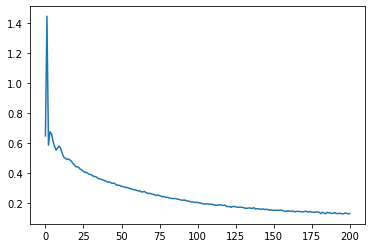

test auc 0.885315041729491


In [8]:
train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = prepare_edge_data(G_cora)
lr = 0.01
layers = [2, 5]
hidden_features = [16, 32, 64]
if_activate = [True, False]
if_normal = [True, False]
if_dropout = [True, False]
best_param_cora = {"loop": None, "layers": None, "if_activate": None, "if_normal": None, "if_dropout": None, "auc": 0.0}

for h_f in hidden_features:
    for l in layers:
        for a in if_activate:
            for n in if_normal:
                for d in if_dropout:
                    print("layers", l, "hidden_features", h_f, "if_activate", a, "if_normal", n, "if_dropout", d)
                    model = GCN(G_cora.ndata['feat'].shape[1], h_f, layers=l, if_activate=a, if_normal=n, if_dropout=d)
                    pred = DotPredictor()
                    best_val_auc, _ = train(train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g, model, pred, epochs=201, print_epoch=100, lr=lr)
                    if best_val_auc > best_param_cora["auc"]:
                        best_param_cora["layers"] = l
                        best_param_cora["if_activate"] = a
                        best_param_cora["if_dropout"] = d
                        best_param_cora["if_normal"] = n
                        best_param_cora["hidden_features"] = h_f
                        best_param_cora["auc"] = best_val_auc
                    print()


print("Best Parameter")
h_f = best_param_cora["hidden_features"]
l = best_param_cora["layers"]
a = best_param_cora["if_activate"]
n = best_param_cora["if_normal"]
d = best_param_cora["if_dropout"]
print(best_param_cora)
model = GCN(G_cora.ndata['feat'].shape[1], h_f, layers=l, if_activate=a, if_normal=n, if_dropout=d)
pred = DotPredictor()
_, best_test_auc = train(train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g, model, pred, epochs=201, print_epoch=100, lr=lr, if_print=True)
print("test auc", best_test_auc)

layers 2 hidden_features 16 if_activate True if_normal True if_dropout True
In epoch 0, loss: 0.658103883266449, train_auc: 0.784961014153516, val_auc: 0.6229829890165746
In epoch 200, loss: 0.3625699281692505, train_auc: 0.9908617587706031, val_auc: 0.8616686664814918
Test AUC 0.859585447945401

layers 2 hidden_features 16 if_activate True if_normal True if_dropout False
In epoch 0, loss: 0.6382929086685181, train_auc: 0.8489106924775849, val_auc: 0.6816133613869682
In epoch 200, loss: 0.12468383461236954, train_auc: 0.9967690345308233, val_auc: 0.8394071851641104
Test AUC 0.8356146591112275

layers 2 hidden_features 16 if_activate True if_normal False if_dropout True
In epoch 0, loss: 0.6879550814628601, train_auc: 0.7675335275890105, val_auc: 0.5981148137360852
In epoch 200, loss: 0.3829568326473236, train_auc: 0.9799593357709708, val_auc: 0.8419576519062715
Test AUC 0.8363214352785326

layers 2 hidden_features 16 if_activate True if_normal False if_dropout False
In epoch 0, loss: 0

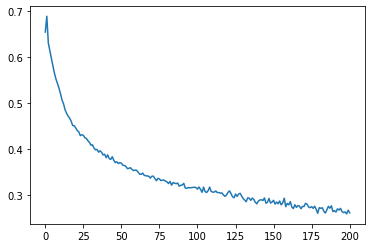

test auc 0.8575106634924526


In [7]:
train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = prepare_edge_data(G_citeseer)
lr = 0.01
layers = [2, 5]
hidden_features = [16, 32, 64]
if_activate = [True, False]
if_normal = [True, False]
if_dropout = [True, False]
best_param_citeseer = {"loop": None, "layers": None, "if_activate": None, "if_normal": None, "if_dropout": None, "auc": 0.0}

for h_f in hidden_features:
    for l in layers:
        for a in if_activate:
            for n in if_normal:
                for d in if_dropout:
                    print("layers", l, "hidden_features", h_f, "if_activate", a, "if_normal", n, "if_dropout", d)
                    model = GCN(G_citeseer.ndata['feat'].shape[1], h_f, layers=l, if_activate=a, if_normal=n, if_dropout=d)
                    pred = DotPredictor()
                    best_val_auc, _ = train(train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g, model, pred, epochs=201, print_epoch=200, lr=lr)
                    if best_val_auc > best_param_citeseer["auc"]:
                        best_param_citeseer["layers"] = l
                        best_param_citeseer["if_activate"] = a
                        best_param_citeseer["if_dropout"] = d
                        best_param_citeseer["if_normal"] = n
                        best_param_citeseer["hidden_features"] = h_f
                        best_param_citeseer["auc"] = best_val_auc
                    print()
    
print("Best Parameter")
h_f = best_param_citeseer["hidden_features"]
l = best_param_citeseer["layers"]
a = best_param_citeseer["if_activate"]
n = best_param_citeseer["if_normal"]
d = best_param_citeseer["if_dropout"]
print(best_param_citeseer)
model = GCN(G_citeseer.ndata['feat'].shape[1], h_f, layers=l, if_activate=a, if_normal=n, if_dropout=d)
pred = DotPredictor()
_, best_test_auc = train(train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g, model, pred, epochs=201, print_epoch=200, lr=lr, if_print=True)
print("test auc", best_test_auc)

layers 2 hidden_features 16 if_activate True if_normal True if_dropout True
In epoch 0, loss: 0.6615186333656311, train_auc: 0.7527437753385775, val_auc: 0.740675834229984
In epoch 20, loss: 0.6389572620391846, train_auc: 0.7485553492924035, val_auc: 0.7393189959355444
In epoch 40, loss: 0.6318160891532898, train_auc: 0.7643517629645004, val_auc: 0.7541156378190618
In epoch 60, loss: 0.6280354857444763, train_auc: 0.7694762801210534, val_auc: 0.7578141757758798
In epoch 80, loss: 0.6236305236816406, train_auc: 0.776364263619828, val_auc: 0.7625042139079137
In epoch 100, loss: 0.6200175285339355, train_auc: 0.78054973161286, val_auc: 0.7639596377966826
In epoch 120, loss: 0.6170827746391296, train_auc: 0.7859380874808357, val_auc: 0.7677543890771159
In epoch 140, loss: 0.6151933670043945, train_auc: 0.7898268622889263, val_auc: 0.7701085954145528
In epoch 160, loss: 0.6136417984962463, train_auc: 0.791951645991966, val_auc: 0.7715414271582497
In epoch 180, loss: 0.6140868663787842, trai

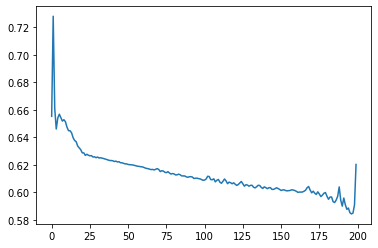

test auc 0.7725148094720773


In [8]:
train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = prepare_edge_data(G_ppi, if_ppi=True)
lr = 0.01
layers = [2, 5]
hidden_features = [16, 32, 64]
if_activate = [True, False]
if_normal = [True, False]
if_dropout = [True, False]
best_param_ppi = {"loop": None, "layers": None, "if_activate": None, "if_normal": None, "if_dropout": None, "auc": 0.0}

for h_f in hidden_features:
    for l in layers:
        for a in if_activate:
            for n in if_normal:
                for d in if_dropout:
                    print("layers", l, "hidden_features", h_f, "if_activate", a, "if_normal", n, "if_dropout", d)
                    model = GCN(G_ppi.ndata['feat'].shape[1], h_f, layers=l, if_activate=a, if_normal=n, if_dropout=d)
                    pred = DotPredictor()
                    best_val_auc, _ = train(train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g, model, pred, epochs=200, print_epoch=20, lr=lr)
                    if best_val_auc > best_param_ppi["auc"]:
                        best_param_ppi["layers"] = l
                        best_param_ppi["if_activate"] = a
                        best_param_ppi["if_dropout"] = d
                        best_param_ppi["if_normal"] = n
                        best_param_ppi["hidden_features"] = h_f
                        best_param_ppi["auc"] = best_val_auc
                    print()
    
print("Best Parameter")
h_f = best_param_ppi["hidden_features"]
l = best_param_ppi["layers"]
a = best_param_ppi["if_activate"]
n = best_param_ppi["if_normal"]
d = best_param_ppi["if_dropout"]
print(best_param_ppi)
model = GCN(G_ppi.ndata['feat'].shape[1], h_f, layers=l, if_activate=a, if_normal=n, if_dropout=d)
pred = DotPredictor()
_, best_test_auc = train(train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g, model, pred, epochs=200, print_epoch=20, lr=lr, if_print=True)
print("test auc", best_test_auc)